# Import some stuff

In [1]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 41.1 MB/s eta 0:00:0000:0100:01


In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm


import numpy as np
import pandas as pd



import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
%matplotlib inline
from torchvision.utils import make_grid

# Dataset processing

In [5]:
image_size = 64
batch_size = 12
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

dataset=ImageFolder("../input/animefacedataset/", transform=T.Compose([T.Resize(image_size), T.CenterCrop(image_size),T.ToTensor(),T.Normalize(*stats)]))
train_dataloader=DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Showing picrure

In [21]:
len(dataset)

63565

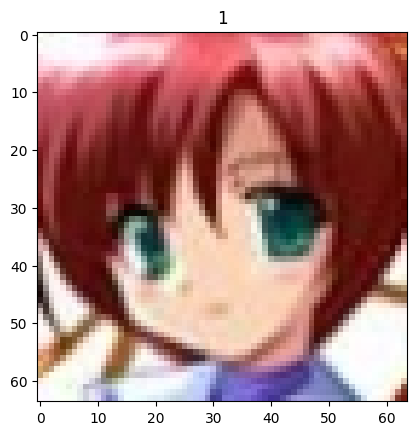

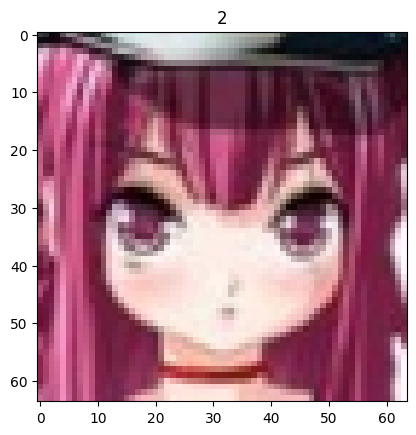

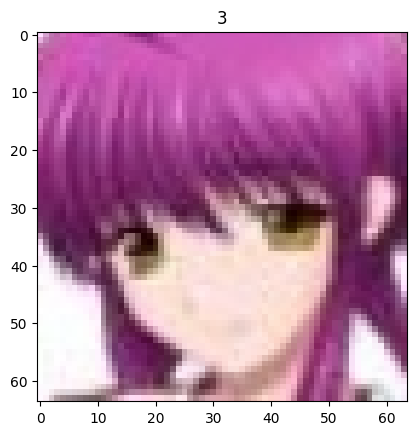

In [6]:
def show_input(input_tensor, title=''):
    plt.imshow(input_tensor.permute(1, 2, 0))
    plt.title(title)
    plt.show()
    plt.pause(0.001)
def show_head(dataset,number):
    for i in range(1,number+1):
        show_input(dataset[i][0]*stats[1][0] + stats[0][0],str(i))
show_head(dataset,3)        

In [7]:
#train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_images_1(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

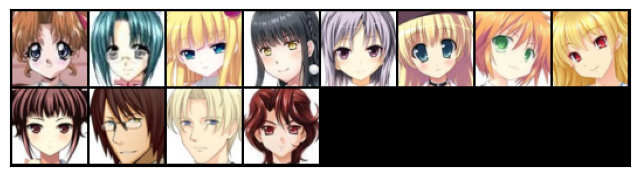

In [8]:
show_batch(train_dataloader)

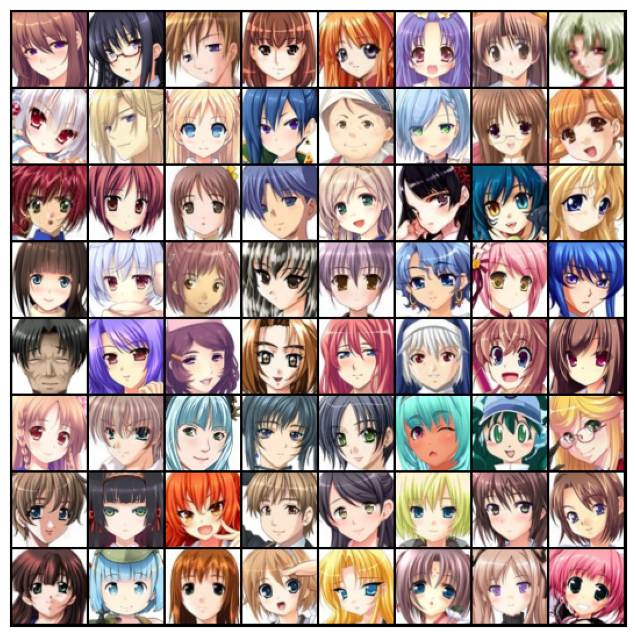

# For GPU using

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Set model

In [9]:
model = UNet2DModel(
            sample_size=64,  # the target image resolution
            in_channels=3,  # Additional input channels for class cond.
            out_channels=3,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",  # a regular ResNet upsampling block
            ),
        )

# Showing input of model

In [11]:
xb = torch.randn(batch_size,3,64, 64)
tb=torch.randn(batch_size)
fake=model.forward(xb,tb).sample


In [19]:
fake.shape

torch.Size([128, 3, 64, 64])

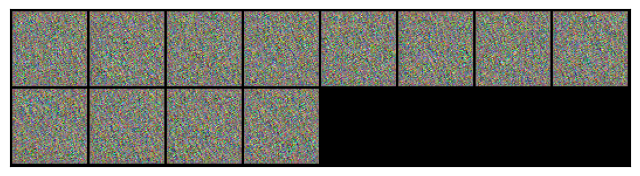

In [12]:
show_images(fake)

# Train ceil

In [11]:
def trainDDPM(data_loader,model,opt,scheduler,loss_fn,epochs,device):
  losses = []
  # The training loop
  for epoch in range(n_epochs):
      for x in tqdm(train_dataloader):

          # Get some data and prepare the corrupted version
          x_ = x[0].to(device)
          #y = x[0].clone().detach()
          noise = torch.randn_like(x_).to(device)
          timesteps = torch.randint(0, 999, (x_.shape[0],)).long().to(device)
          noisy_x = scheduler.add_noise(x_, noise, timesteps)
          

          # Get the model prediction
          pred = model(noisy_x, timesteps)  # Note that we pass in the labels y

          # Calculate the loss
          loss = loss_fn(pred.sample, noise).to(device)  # How close is the output to the noise

          # Backprop and update the params:
          opt.zero_grad()
          loss.backward()
          opt.step()

          # Store the loss for later
          losses.append(loss.item())

      # Print out the average of the last 100 loss values to get an idea of progress:
      avg_loss = sum(losses[-100:]) / 100
      print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}")

In [12]:
device = get_default_device()

In [13]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,)
loss=torch.nn.MSELoss()
n_epochs=5

train_dl = DeviceDataLoader(train_dataloader, device)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [14]:
trainDDPM(train_dl,model,optimizer,noise_scheduler,loss,n_epochs,device)

  0%|          | 0/5298 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.048257


  0%|          | 0/5298 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.048249


  0%|          | 0/5298 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.044707


  0%|          | 0/5298 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.041510


  0%|          | 0/5298 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.044541


In [15]:
torch.save(model.state_dict(),'Anime_1.pth')

In [42]:
x = torch.randn(8, 3, 64, 64).to(device)
# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model(x, t).sample  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample



0it [00:00, ?it/s]

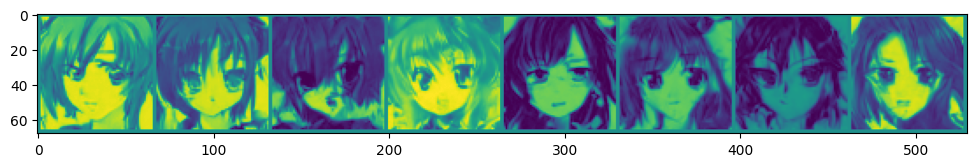

In [25]:
# Show the results

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0])

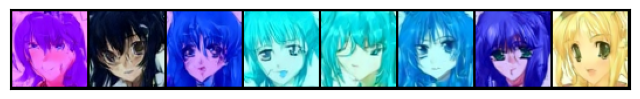

In [34]:
show_images(x.detach().cpu(),8)

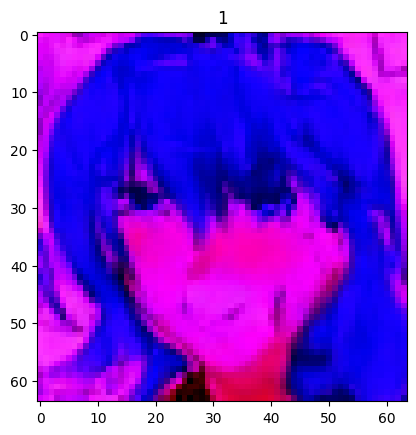

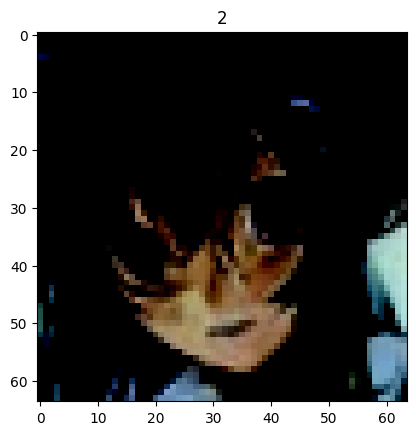

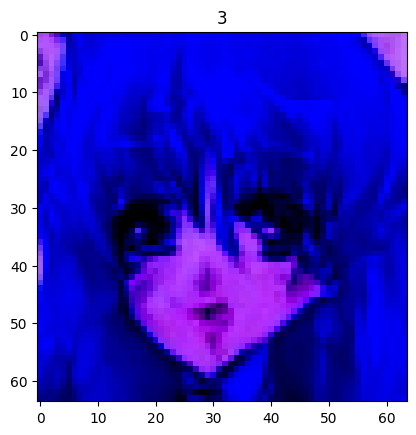

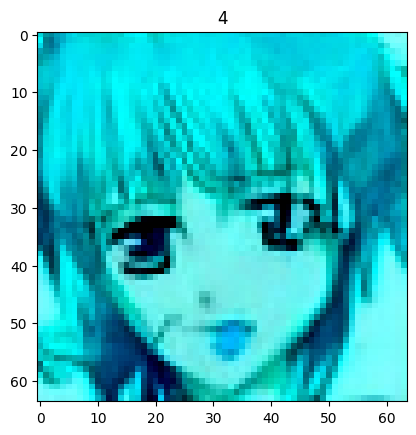

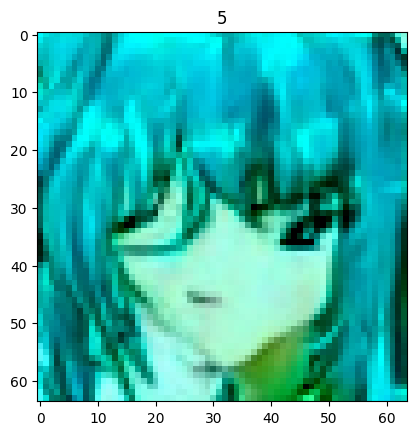

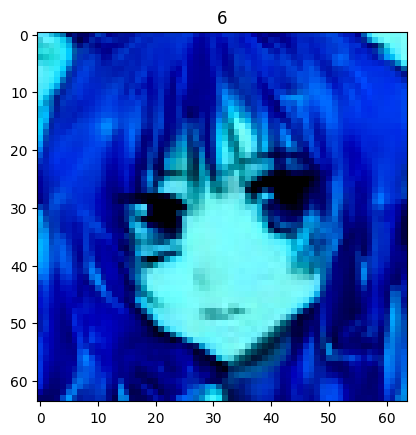

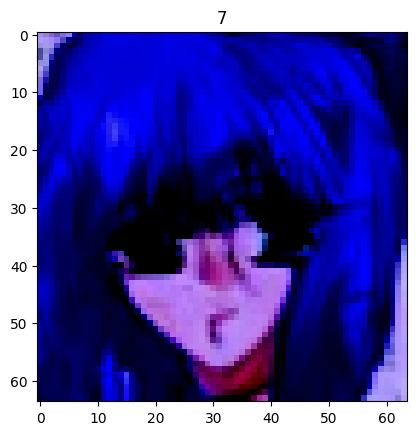

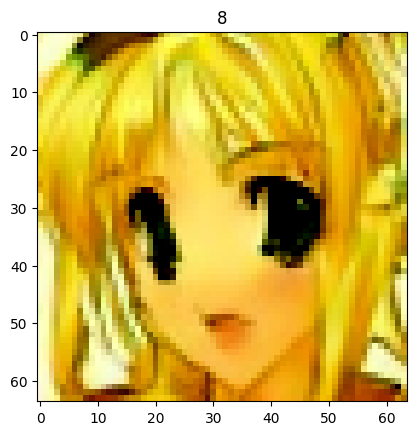

In [41]:
for i in range(8):
    show_input(x.detach().cpu()[i],str(i+1))

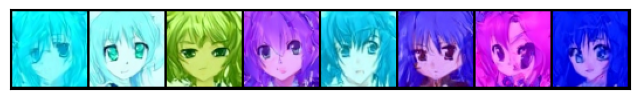

In [32]:
show_images(x.detach().cpu(),8)

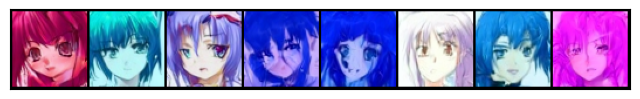

In [30]:
show_images(x.detach().cpu(),8)

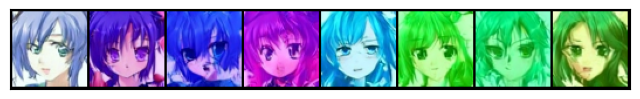

In [28]:
show_images(x.detach().cpu(),8)

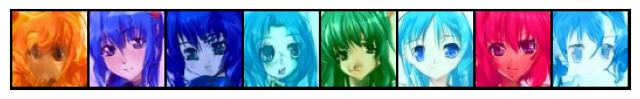

In [43]:
show_images(x.detach().cpu(),8)

# Reverse diffusion process showing

In [ ]:
model = UNet2DModel(
            sample_size=64,  # the target image resolution
            in_channels=3,  # Additional input channels for class cond.
            out_channels=3,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",  # a regular ResNet upsampling block
            ),
        )

In [ ]:
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()

In [16]:
x = torch.randn(1, 3, 64, 64).to(device)
# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    if i%50==0:
       show_input(x.detach().cpu(),str(i+1))
    # Get model pred
    with torch.no_grad():
        residual = model(x, t).sample  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample


0it [00:00, ?it/s]

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3